## Importing Libraries

In [1]:
# Database
import sqlite3

# Data Wrangling
import re, numpy as np, pandas as pd
from pandas.api.types import is_object_dtype
from sklearn.preprocessing import KBinsDiscretizer

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.patches import Patch

# Association Rule Mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpmax, association_rules


## 1. Data Ingestion from .db file
* Get Table name from .db file
* Query .db file for records
* Query .db file for Column headers

In [2]:
# 1.0 - Open an connection to the Database file
conn = sqlite3.connect('../data/raw/bmarket.db')

# 1.1 - Set up the cursor object
cursor = conn.cursor()

# 1.2 - Execute the SQL query and extract the table name
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tbl_name = tables[0][0]

# 1.3 - Execute a SELECT query to retrieve all data from the table - score
cursor.execute(f"SELECT * FROM {tbl_name}")
rows = cursor.fetchall()

# 1.4 - Execute the query and retrieve column headers of the table
cursor.execute(f"PRAGMA table_info({tbl_name})")
columns_info = cursor.fetchall()
column_names = [info[1] for info in columns_info]

# 1.5 - Close the cursor and the connection
cursor.close()
conn.close()


print(tbl_name)
print(column_names)

bank_marketing
['Client ID', 'Age', 'Occupation', 'Marital Status', 'Education Level', 'Credit Default', 'Housing Loan', 'Personal Loan', 'Contact Method', 'Campaign Calls', 'Previous Contact Days', 'Subscription Status']


## 2. Creating the Dataset from Query results

In [3]:
# 2.0 - Create a pd DataFrame from the query results - rows
client_details_df = pd.DataFrame(rows, columns = column_names)

# 2.1 - Reorder the DataFrame, reset index and exclude the Client ID for better clarity
client_details_df = client_details_df.sort_values(by = ['Client ID'], ascending = True)
client_details_df.drop(columns = ['Client ID'], inplace = True)
client_details_df.reset_index(inplace = True, drop = True)

print(f"DataFrame has {client_details_df.shape[0]} rows & {client_details_df.shape[1]} columns")
display(client_details_df.head(5))

DataFrame has 41188 rows & 11 columns


,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,56 years,housemaid,married,basic.4y,no,no,no,telephone,1,999,no
1,150 years,services,married,high.school,unknown,no,no,Telephone,1,999,no
2,37 years,services,married,high.school,no,None,no,telephone,1,999,no
3,150 years,admin.,married,basic.6y,no,no,no,Telephone,-1,999,no
4,56 years,services,married,high.school,no,None,yes,Telephone,1,999,no


## Custom Functions
* get_unique_values
* check_for_value
* impute_unknown_with_mode
* get_age
* replace_pattern

In [4]:
def get_unique_values(df: pd.DataFrame, column_header = None):
    """
    Finds the unique values in each column of a Pandas DataFrame.

    Args:
        df: A Pandas DataFrame.
        column_header: (Optional) A string specifying the column header.
                     If provided, returns the unique values of that column only.
                     If None, returns a dictionary of unique values for all columns.

    Returns:
        A dictionary where keys are column names and values are lists of unique values in that column.
        If column_header is None:
            A dictionary where keys are column headers and values are lists of unique values
            in that column.
        If column_header is provided:
            A list of unique values in the specified column.
            Displays an error message if the column does not exist.
        Displays an error message if the input is not a DataFrame or is empty.
    """
    if not isinstance(df, pd.DataFrame):
        print("Error: Input must be a Pandas DataFrame.")

    if df.empty:
        print("Warning: The DataFrame is empty.")

    unique_values = {}
    for column in df.columns.to_list():
        column = str(column)
        unique_values[column] = df[column].unique().tolist()  # Convert to list for easier handling

    if (column_header is None):
      return unique_values
    else:
      if (column_header not in df.columns.to_list()):
        print(f"{column_header} not found")
      else:
        return unique_values[column_header]

def check_for_value(unique_val_dict, value):
    """
    Checks which columns in a dictionary of unique values contain a specified value.

    Args:
        unique_val_dict: A dictionary where keys are column headers and values are lists of unique values
            found in those columns. This is the output from get_unique_values()
        list_of_col_headers: A list of column headers to check within the 'unique_val_dict'.
        value: The value to search for within the lists of unique values.

    Returns:
        A list of column headers from `list_of_col_headers` that contain the specified `value`.
        Returns an empty list if no columns contain the value, if `unique_val_dict`
        is empty, or if `list_of_col_headers` is empty.
    """
    col_with_value = []
    for col_header, col_values in unique_val_dict.items():
      if value in col_values:
        col_with_value.append(col_header)
    return col_with_value

def impute_unknown_with_mode(df, list_of_col_headers: list):
  for header in list_of_col_headers:
    col_mode = df[header][df[header] != 'unknown'].mode()[0]
    print(f"Column {header} Mode Value: {col_mode}")
    df[header] = df[header].replace(to_replace = 'unknown', value = col_mode)
  return df



In [5]:
# Remove 'years' from 'Age' to get client's age in numerical form
def get_age(age_string: str):
    """
    Extracts the age from a string.

    Args:
        age_string: A string containing the age, possibly with extra text.
                    For example: "25 years", "30 years"
                    Handles cases where the string is None or empty.

    Returns:
        The age as an integer, or None if the string is invalid or None.
    """
    if not isinstance(age_string, str) or not age_string.strip():
        print("Input must not be empty or must be a string")

    try:
        # Split the string by spaces and try to convert the first part to an integer
        age = int(age_string.split(" ")[0])
        return age
    except (ValueError, IndexError):
        # Handle cases where the string doesn't start with a number or is badly formatted
        return None


In [6]:
def replace_pattern(string_with_pattern: str, pattern_to_replace:str, new_pattern:str) -> str:
  """
    Replaces all occurrences of the string from 'pattern_to_replace' with the string from 'new_pattern' in a given column.

    Args:
        edu_string: The string to modify.

    Returns:
        edu_string: The modified string with underscores replacing dots.
        Returns the original string if it is not a string.
  """

  regex_pattern = re.escape(pattern_to_replace)
  if (re.search(regex_pattern, string_with_pattern)):
    string_with_pattern = re.sub(regex_pattern,new_pattern, string_with_pattern)
  return string_with_pattern

## 3. Data Cleaning & Transformation
* The objective is to clean and transform the data, making it suitable for analysis.
  * Check unique values to understand data quality
  * get Client's age from 'Age' column
  * Clean 'Education Level' for conformity
  * Standardize the values of 'Contact Method'
  * Transform negative value to positive values with abs()
  * Remove unknown values within the DataFrame


In [7]:
# 3.0 Check Uniques values to understand Data Quality
unique_vals_dict = get_unique_values(client_details_df)
print(unique_vals_dict)

{'Age': ['56 years', '150 years', '37 years', '45 years', '59 years', '41 years', '24 years', '25 years', '29 years', '57 years', '35 years', '46 years', '50 years', '39 years', '30 years', '55 years', '54 years', '49 years', '34 years', '52 years', '58 years', '32 years', '38 years', '44 years', '42 years', '40 years', '60 years', '53 years', '47 years', '51 years', '33 years', '31 years', '43 years', '48 years', '36 years', '28 years', '27 years', '26 years', '22 years', '23 years', '20 years', '21 years', '61 years', '19 years', '18 years', '66 years', '76 years', '67 years', '73 years', '88 years', '95 years', '70 years', '77 years', '68 years', '75 years', '63 years', '80 years', '62 years', '65 years', '72 years', '82 years', '64 years', '69 years', '71 years', '78 years', '85 years', '79 years', '83 years', '81 years', '74 years', '17 years', '91 years', '86 years', '98 years', '84 years', '92 years', '89 years'], 'Occupation': ['housemaid', 'services', 'admin.', 'blue-collar', 

In [8]:
# 3.1 Get Client's age by transforming 'Age' column
example_age = client_details_df.loc[1,'Age']
print(example_age, type(example_age))

client_details_df['Age'] = client_details_df['Age'].apply(get_age)

numeric_age = client_details_df['Age'].max()

print(numeric_age, type(numeric_age))

150 years <class 'str'>
150 <class 'numpy.int64'>


In [9]:
# 3.2 Clean up the 'Education Level' column to conform with proper naming convention
edu_lvl = get_unique_values(client_details_df, 'Education Level')
print(edu_lvl)

client_details_df['Education Level'] = client_details_df['Education Level'].apply(replace_pattern,pattern_to_replace = ".", new_pattern = "_")

edu_lvl = get_unique_values(client_details_df, 'Education Level')
print(edu_lvl)


['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
['basic_4y', 'high_school', 'basic_6y', 'basic_9y', 'professional_course', 'unknown', 'university_degree', 'illiterate']


In [10]:
# 3.3 - Standardize the values of the 'Contact Method' column to conform proper naming convention; ['Telephone','cellular'] -> ['telephone','cell']
client_details_df['Contact Method'] = client_details_df['Contact Method'].replace(to_replace = {'Telephone':'telephone', 'cellular':'Cell'})
client_details_df['Contact Method'] = client_details_df['Contact Method'].str.lower()

print(get_unique_values(client_details_df,'Contact Method'))

['telephone', 'cell']


In [11]:
# 3.4 Standardize 'admin' to conform proper naming convention
client_details_df['Occupation'] = client_details_df['Occupation'].apply(replace_pattern,pattern_to_replace = ".", new_pattern = "")
print(get_unique_values(client_details_df,'Occupation'))

['housemaid', 'services', 'admin', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']


In [12]:
# 3.5 Transform negative values in 'Campaign Calls' for clarity
client_details_df['Campaign Calls'] = client_details_df['Campaign Calls'].abs()

neg_value_count = client_details_df['Campaign Calls'][client_details_df['Campaign Calls'] < 0].count()

print(f"No. of Negative Values in 'Campaign Calls': {neg_value_count}")

No. of Negative Values in 'Campaign Calls': 0


In [13]:
# 3.6 Check the number of null values in the dataset
null_count = client_details_df.isnull().sum().to_frame(name = "count").reset_index()
count_mask = null_count['count'] > 0  
display(null_count[count_mask])


,index,count
5,Housing Loan,24789
6,Personal Loan,4146


In [14]:
# 3.7 Replace unknown as null and check the number of nulls 
unknown_as_null_df = client_details_df.replace(to_replace = {'unknown': np.nan})
unknown_as_null_count = unknown_as_null_df.isnull().sum().to_frame(name = "count").reset_index()
unknown_as_null_mask = unknown_as_null_count['count'] > 0  
display(unknown_as_null_count[unknown_as_null_mask])

,index,count
1,Occupation,330
2,Marital Status,80
3,Education Level,1731
4,Credit Default,8597
5,Housing Loan,25182
6,Personal Loan,5023


## 4. Categorical Variables Check-in
* Occupation
* Education Level
* Marital Status
* Credit Default
* Housing Loan
* Personal Loan
* Contact Method


In [15]:
print(client_details_df.shape)
client_details_cat_df = client_details_df.select_dtypes(exclude=['number'])
print(client_details_cat_df.columns)


(41188, 11)
Index(['Occupation', 'Marital Status', 'Education Level', 'Credit Default',
       'Housing Loan', 'Personal Loan', 'Contact Method',
       'Subscription Status'],
      dtype='object')


### Target Variable - 'Subscription Status'

C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\591441013.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = client_details_cat_df, x = 'Subscription Status',
C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\591441013.py:14: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data = client_details_cat_df, x = 'Subscription Status',


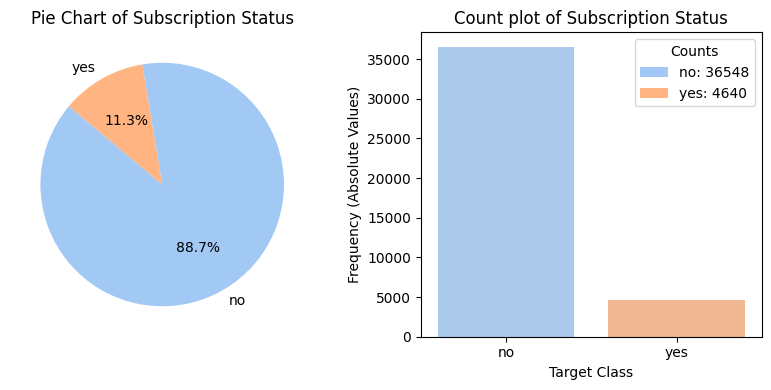

In [16]:
# Explore the Target variable - Subscription Status
target_value_count = client_details_cat_df['Subscription Status'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].pie(
    target_value_count,
    labels = target_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title('Pie Chart of Subscription Status')

sns.countplot(data = client_details_cat_df, x = 'Subscription Status',
              order = target_value_count.index,
              ax = axes[1], orient = "v",
              palette=sns.color_palette('pastel'))
axes[1].set_title('Count plot of Subscription Status')
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Frequency (Absolute Values)')
axes[1].tick_params(axis='x')

# Add legend with absolute values
legend_elements = [
    Patch(facecolor=sns.color_palette('pastel')[i], label=f"{cat}: {count}")
    for i, (cat, count) in enumerate(target_value_count.items())
]
axes[1].legend(handles=legend_elements, title="Counts", loc='upper right')



plt.tight_layout()
plt.show()

#### Analysis on 'Subscription Status'
---
Based on the pie chart presented on the target variable - 'Subscription Status', an imbalance in classes is observed.  

 The majority class (`no`) dominates at 36,548 counts (88.7%), The minority class (`yes`) is only at 4,640 counts (11.3%). This imbalance could pose as a problem for our predictive model as the minority class may not be picked up owning to its rarity, and our predictive models may not be able to learn the important pattern related to the minority class.

### Predictor Variable - 'Occupation'

In [17]:
# 'Occupation' Feature
occupation_value_count = client_details_cat_df['Occupation'].value_counts()
occupation_value_count_percent = client_details_cat_df['Occupation'].value_counts(normalize = True)
occupation_value_count_percent = (occupation_value_count_percent*100).round(2)
occupation_df = pd.concat([occupation_value_count.rename('Count'), occupation_value_count_percent.rename('Proportion (%)')], axis=1)
display(occupation_df)

,Count,Proportion (%)
Occupation,,
admin,10422,25.30
blue-collar,9254,22.47
technician,6743,16.37
services,3969,9.64
management,2924,7.10
retired,1720,4.18
entrepreneur,1456,3.54
self-employed,1421,3.45
housemaid,1060,2.57


C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\665413293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_response.sort_values(by = ['yes'], ascending = False, inplace = True)
C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\665413293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_response['yes'] = (positive_response['yes']).round(2)


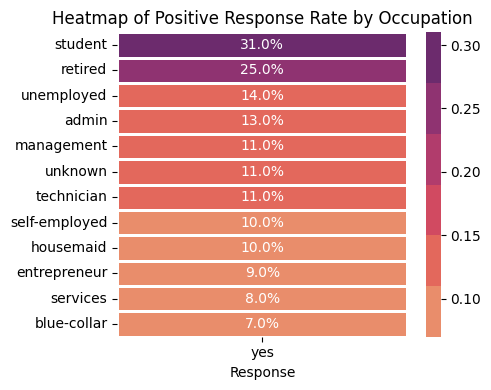

In [18]:
# Plot a Heatmap compare Subscription Status across different occupation
response_rate = (client_details_cat_df.groupby('Occupation')['Subscription Status'].value_counts(normalize=True).unstack().fillna(0))
positive_response = response_rate[['yes']]
positive_response.sort_values(by = ['yes'], ascending = False, inplace = True)
positive_response['yes'] = (positive_response['yes']).round(2)
# print(positive_response)

plt.figure(figsize=(5, 4))
sns.heatmap(positive_response, annot = True,
            cmap = sns.color_palette("flare"), fmt = '.1%',
            linewidths = 1)
plt.title('Heatmap of Positive Response Rate by Occupation')
plt.xlabel('Response')
plt.ylabel('')
plt.tight_layout()
plt.show()


#### Analysis on 'Occupation'
---
The `Occupation` variable has the highest cardinality with 11 classes. There's moderate amount of class imbalance as 3 classes (`admin`, `blue-collar` and `technician`) collectively contributes up to 70.0% of our sample. The `unknown` class only contributes a minuscule portion (0.8%) of our sample, this class will be removed considering it doesn't provide any valuable information about customers. Furthermore, we do not have any source of truth for reference to impute this class.

The heatmap displays positive response rate for each occupation. As observed, the top two occupations with positive response ()`student`, `retired`) leads with a decent margin. One rationale for these top occupation could be due to their lower risk appetite given their (or lack thereof) earning power.


### Predictor variable - 'Education Level' 

,Education Level,Subscription Status,count,Proportion
0,basic_4y,no,3748,0.90
1,basic_4y,yes,428,0.10
2,basic_6y,no,2104,0.92
3,basic_6y,yes,188,0.08
4,basic_9y,no,5572,0.92
5,basic_9y,yes,473,0.08
6,high_school,no,8484,0.89
7,high_school,yes,1031,0.11
8,illiterate,no,14,0.78
9,illiterate,yes,4,0.22


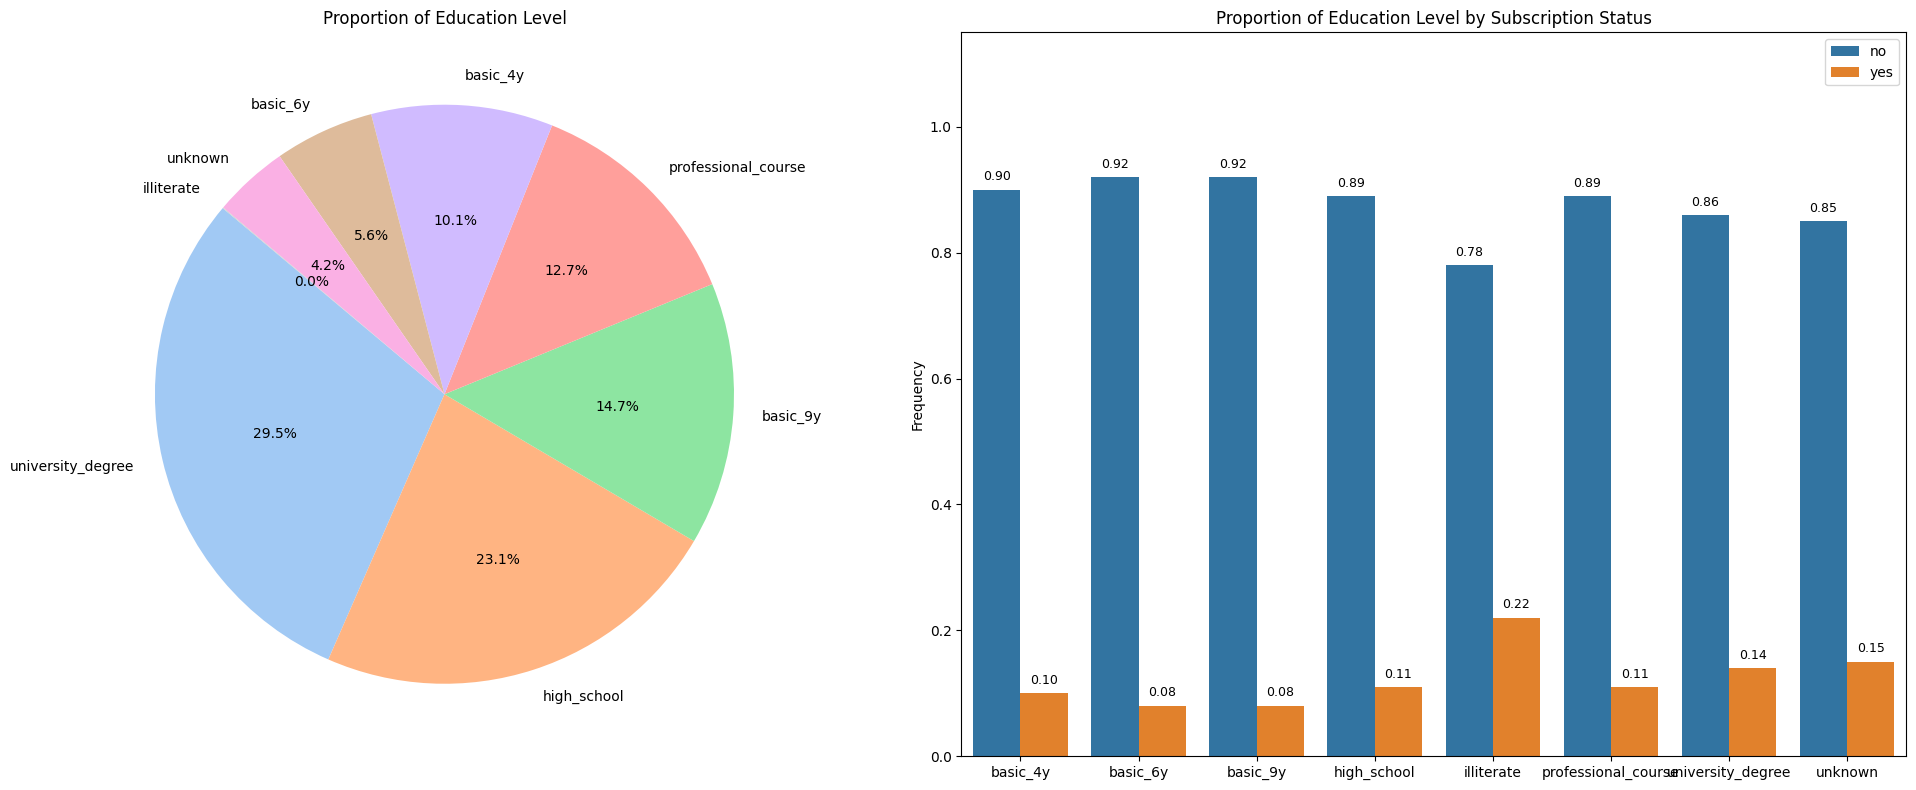

In [19]:
# Education Level
col_name = 'Education Level'
fig, axes = plt.subplots(1, 2, figsize=(20,8))
edu_value_count = client_details_cat_df[f'{col_name}'].value_counts()

axes[0].pie(
    edu_value_count,
    labels = edu_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(2)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of {col_name} by Subscription Status')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
# Numerical Breakdown of Age after removing outlier
age_mask = client_details_df['Age'] == 150
age_masked_df = client_details_df[~age_mask]
display(age_masked_df.groupby('Education Level')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Education Level,,,,,,,,
basic_4y,3734.0,47.594804,12.180709,18.0,39.0,47.0,55.00,98.0
basic_6y,2055.0,40.535280,8.704977,18.0,34.0,39.0,46.00,95.0
basic_9y,5427.0,39.105215,9.585925,17.0,32.0,38.0,46.00,86.0
high_school,8553.0,37.969484,9.695040,18.0,31.0,36.0,44.00,88.0
illiterate,16.0,48.500000,11.407600,34.0,43.5,48.0,51.75,80.0
professional_course,4707.0,40.048226,9.860265,20.0,33.0,38.0,47.00,86.0
university_degree,10924.0,38.884749,9.659259,20.0,32.0,36.0,45.00,91.0
unknown,1575.0,43.504762,12.576771,17.0,35.0,43.0,52.00,92.0


#### Analysis on 'Education Level'
---
The `Education Level` variable has high cardinality with 7 levels with slight levels of class imbalance. The `illiterate` class having the least proportion (~0%) while `university_degree` class having the greatest proportion (29.5%).

The different class, apart from `illiterate` (~0%), have relatively similar response rate, with education levels above (and inclusive of) `high_school` having higher positive response rate(ranging from 11% - 15%).

There are several options to handle the `unknown` class.   
* The first option is to the remove these rows as they only represent ~4% of our sample. 
* The second option is to impute with an existing class. The second options will require further analysis and domain knowledge to determine the ideal class to impute with. 

Ad-hoc Analysis - Education Level vs. Age (after removing outliers)
* `Education` Level can be profiled into two distinct groups (lower education - Older age & higher education - Younger Age)
* The profile for `unknown` seems to fit better into the first group - lower education - Older age
* Basic_4y vs. basic_6y - basic_4y seems to be a better fit





### Predictor Variable - 'Marital Status'

,Marital Status,Subscription Status,count,Proportion
0,divorced,no,4136,0.90
1,divorced,yes,476,0.10
2,married,no,22396,0.90
3,married,yes,2532,0.10
4,single,no,9948,0.86
5,single,yes,1620,0.14
6,unknown,no,68,0.85
7,unknown,yes,12,0.15


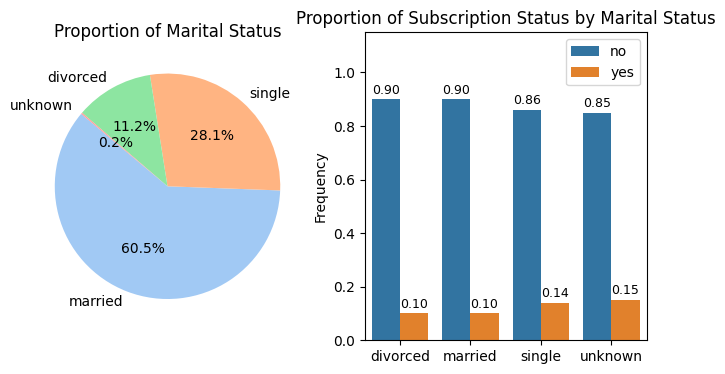

In [21]:
# Marital Status
col_name = 'Marital Status'
fig, axes = plt.subplots(1, 2, figsize=(8,4))
marital_value_count = client_details_cat_df[f'{col_name}'].value_counts()

axes[0].pie(
    marital_value_count,
    labels = marital_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(2)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of Subscription Status by {col_name}')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

# plt.tight_layout()
plt.show()


#### Analysis on 'Marital Status'
---
The pie chart indicates moderate class imbalance with the `married` class taking the highest proportion (60.5%), followed by the `single` class (28.1%), the `divorced` class (11.2%) and the `unknown` class having the least proportion (0.2%). Given the rarity of the `unknown` class (0.2%), these records can be safely removed due the limited impact of these records.

The three marital status have relatively similar proportion of customers who responded positively, with `single` customers being more likely to respond positively.

### Predictor Variable - 'Credit Default'

,Credit Default,Subscription Status,count,Proportion
0,no,no,28391,0.87
1,no,yes,4197,0.13
2,unknown,no,8154,0.95
3,unknown,yes,443,0.05
4,yes,no,3,1.00


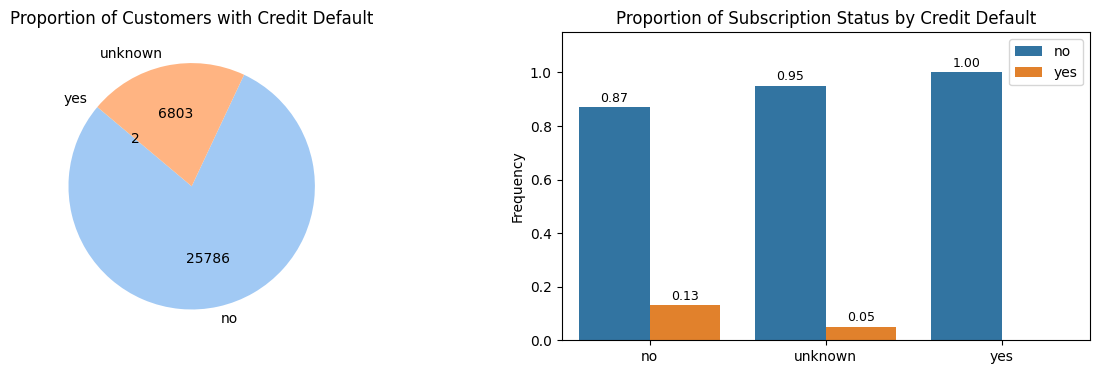

In [22]:
 # Credit Default
col_name = 'Credit Default'
fig, axes = plt.subplots(1, 2, figsize=(15,4))
credit_value_count = client_details_cat_df[f'{col_name}'].value_counts()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val:d}'
    return my_autopct

axes[0].pie(
    credit_value_count,
    labels = credit_value_count.index,
    autopct = make_autopct([credit_value_count[['yes']].item(),credit_value_count[['no']].item()]),
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of Customers with {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(2)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of Subscription Status by {col_name}')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

plt.show()

#### Analysis on 'Credit Default'
---
The pie chart indicates a severe level of class imbalance with the `no` class (25,786 counts) overwhelming the `yes` class (2 counts). 
This poses a problem as predictive models may have difficulty learning the patterns related to the `yes` class due to its rarity.

Customers with `no` credit default are more likely to respond positively while customers with `yes` credit default do not subscribe.

The `unknown` class has 6,803 count which does not offer insights into a subscriber (or non-subscriber) profile. This can be addressed with imputation with domain knowledge as Credit Bureau Singapore reports a low credit fault rates. Therefore, `unknown` class is imputed with `no` class. 


### Predictor Variable - 'Housing Loan'

,Housing Loan,Subscription Status,count,Proportion
0,no,no,6573,0.89
1,no,yes,838,0.11
2,unknown,no,341,0.87
3,unknown,yes,52,0.13
4,yes,no,7581,0.88
5,yes,yes,1014,0.12


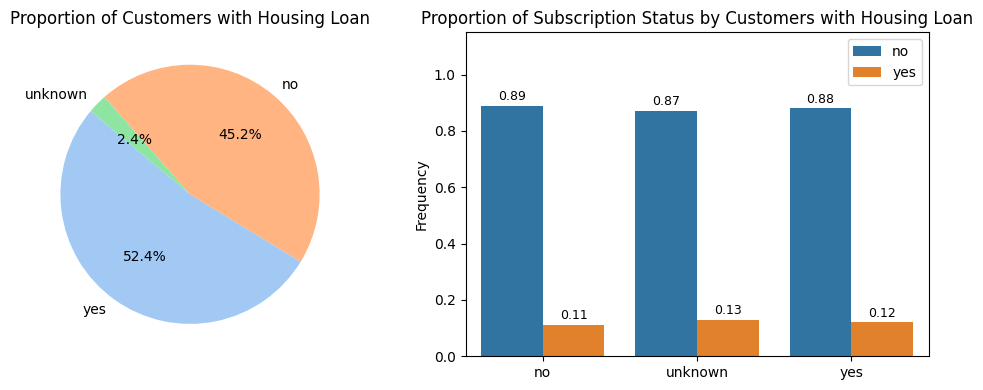

In [23]:
# Housing Loan
col_name = 'Housing Loan'
fig, axes = plt.subplots(1, 2, figsize=(10,4))
housing_value_count = client_details_cat_df[f'{col_name}'].value_counts()

axes[0].pie(
    housing_value_count,
    labels = housing_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of Customers with {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(2)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of Subscription Status by Customers with {col_name}')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Analysis on 'Housing Loan'
---
The pie chart indicates a slight class imbalance with the `no` class at 45.2%, the `yes` class is at 52.4% and `unknown` class with the least proportion at 2.4%

The positive response rates are relatively similar across the aboard, with the `yes` class being more likely to respond positively.  

The `unknown` class does not offer any valuable information and should be handled. One option is imputation with domain knowledge. Following the housing loan environment in Singapore, majority of the population are saddled with a housing loan. Therefore, the `unknown` class is imputed with the `yes` class.

### Predictor Value - 'Personal Loan'

,Personal Loan,Subscription Status,count,Proportion
0,no,no,27072,0.8867
1,no,yes,3460,0.1133
2,unknown,no,783,0.8928
3,unknown,yes,94,0.1072
4,yes,no,5019,0.8910
5,yes,yes,614,0.1090


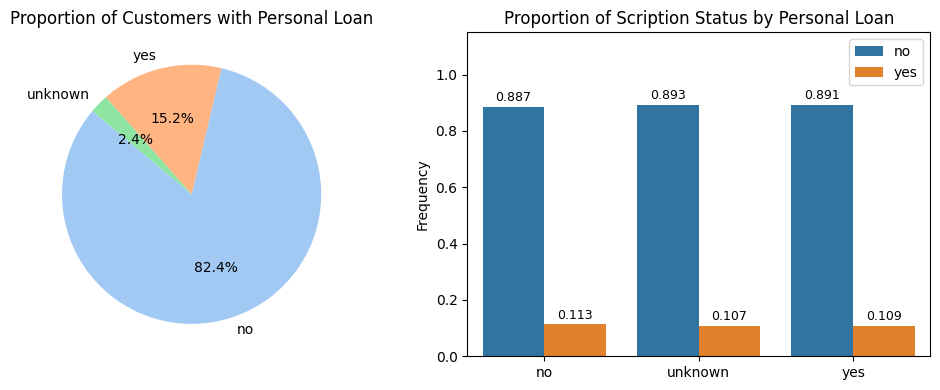

In [24]:
# Personal Loan
col_name = 'Personal Loan'
fig, axes = plt.subplots(1, 2, figsize=(10,4))
personal_value_count = client_details_cat_df[f'{col_name}'].value_counts()

axes[0].pie(
    personal_value_count,
    labels = personal_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of Customers with {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(4)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of Scription Status by {col_name}')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Analysis on 'Personal Loan'
---
Similarly to 'Housing Loan', there is a moderate class imbalance with the `no` class at 82.4%, the `yes` class is at 15.2% and the `unknown` class having the least proportion at 2.4%.   

The positive response rate across the board is relatively similar with slight difference. The `no` class has an higher subscription rate at 11.3% when compared to the other category. 

The `unknown` class does not offer any valuable insight into the a subscriber (or non-subscriber) profile and can be handled accordingly. For the 'Personal Loan' variable, we can impute with the mode value.

### Predictor Variable - 'Contact Method'

,Contact Method,Subscription Status,count,Proportion
0,cell,no,22291,0.85
1,cell,yes,3853,0.15
2,telephone,no,14257,0.95
3,telephone,yes,787,0.05


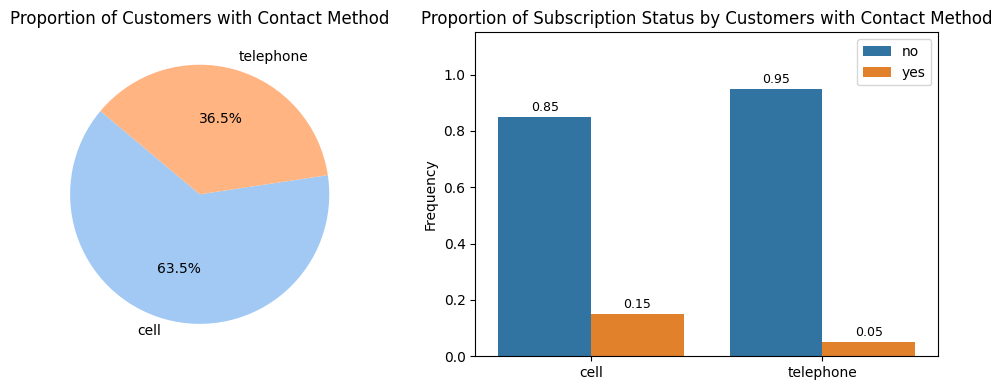

In [25]:
# Housing Loan
col_name = 'Contact Method'
fig, axes = plt.subplots(1, 2, figsize=(10,4))
housing_value_count = client_details_cat_df[f'{col_name}'].value_counts()

axes[0].pie(
    housing_value_count,
    labels = housing_value_count.index,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('pastel')
)
axes[0].set_title(f'Proportion of Customers with {col_name}')

normalized_df = (client_details_cat_df
                 .groupby([f'{col_name}', 'Subscription Status'])
                 .size()
                 .reset_index(name='count'))
normalized_df['Proportion'] = normalized_df.groupby(f'{col_name}')['count'].transform(lambda x: x / x.sum())
normalized_df['Proportion'] = normalized_df['Proportion'].round(2)
display(normalized_df)

barplot = sns.barplot(data = normalized_df,
              x = f'{col_name}',
              y = 'Proportion',
              hue = 'Subscription Status',
              ax = axes[1])

for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            barplot.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
axes[1].set_title(f'Proportion of Subscription Status by Customers with {col_name}')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x')
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Analysis on 'Contact Method'
---------------------------------
An moderate level of class imbalance is observed in this variable with the `cell` class (63.5%) being dominant category and the `telephone`  class (36.5%) being the lesser category.

Between the two classes, the `cell` class has a higher subscription rate (15% vs 5%). This may imply that customer contacted through cellphones instead of telephone are more likely to subscribe.

### Conclusion on Categorical Variables
* Two variables have high cardinality, `Occupation` (11 categories) & `Education Level` (7 cateogories)
* Most of the variable, barring `Credit Default` and `Subscription Status` with severe level of class imbalance, are observed with slight or moderate level of class imbalance   
* Cell value of 'unknown' representing null value which may not provide any meaningful value for analysis are handled in the following manner:
    * Remove rows with 'unknown' values from `Occupation` and `Marital Status`
    * The remaining columns are imputed with the Mode value or values based on Domain knowledge 

### 4.1 Data Transformation on Categorical Values 
* Remove rows with 'unknown' values from `Occupation` and `Marital Status`
* impute 'unknown' values in `Education Level` to basic_4y
* Impute 'unknown' values in `Credit Default` to no
* impute 'unknown' values in `Housing Loan` to yes
* impute 'unknown' values in `Personal Loan` to no

In [26]:
# 4.1 Replace all 'unknown' to NaN value
client_details_df = client_details_df.replace(to_replace = {'unknown': np.nan})

# 4.2 Remove rows with 'unknown' values in 'Occupation' & 'Marital Status'
client_details_df.dropna(subset = ['Occupation', 'Marital Status'], inplace = True) 

# 4.3 Replace NaN using a dictionary
values = {"Education Level":"basic_4y","Credit Default":"no","Housing Loan":"yes","Personal Loan":"no"}
client_details_df.fillna(value = values, inplace = True)

# 4.4 Check our results
print(f"DataFrame has {client_details_df.shape[0]} rows, {client_details_df.shape[1]} columns")
display(client_details_df.isnull().sum().to_frame(name = "count").reset_index())


DataFrame has 40787 rows, 11 columns


,index,count
0,Age,0
1,Occupation,0
2,Marital Status,0
3,Education Level,0
4,Credit Default,0
5,Housing Loan,0
6,Personal Loan,0
7,Contact Method,0
8,Campaign Calls,0
9,Previous Contact Days,0


## 5. Continuous Variable Check-in

In [27]:
# Explore the descriptive statistic of our continuous variables
client_details_cont_df = client_details_df.select_dtypes(include=['number'])
print(client_details_cont_df.columns)

Index(['Age', 'Campaign Calls', 'Previous Contact Days'], dtype='object')


In [28]:
def plot_histo_and_boxplot(df, list_of_column_header):
  header_count = len(list_of_column_header)
  fig = plt.figure(figsize=(10 * max(header_count, 1), 8))
  gs = gridspec.GridSpec(2, header_count, height_ratios=[3, 1], hspace=0.6)

  for index, column_header in enumerate(list_of_column_header):
      mean_val = df[column_header].mean()

      # Plot a Histogram
      ax_hist = fig.add_subplot(gs[0, index])
      ax_hist.axvline(mean_val, color = 'red', linestyle = '--', linewidth = 1, label = f'Mean: {mean_val:.2f}')
      sns.histplot(df[column_header] , kde=True, ax=ax_hist, color='skyblue', edgecolor='black')
      ax_hist.set_title(f'Histogram + KDE of {column_header}', fontsize=14)
      ax_hist.set_ylabel('Density', fontsize=12)
      ax_hist.legend()

      # Plot a Horizontal boxplot
      ax_box = fig.add_subplot(gs[1, index])
      ax_box.boxplot(df[column_header] , vert=False)
      ax_box.axvline(mean_val, color = 'red', linestyle = '--', linewidth = 1)
      ax_box.set_title(f'Boxplot of {column_header}', fontsize=14)
      ax_box.set_yticks([1])
      ax_box.set_yticklabels([column_header], fontsize=12)
  plt.subplots_adjust(wspace=0.4, hspace=0.3)
  plt.show()


### Overview of Continuous Variables
* Age
* Campaign Calls
* Previous Contact Days

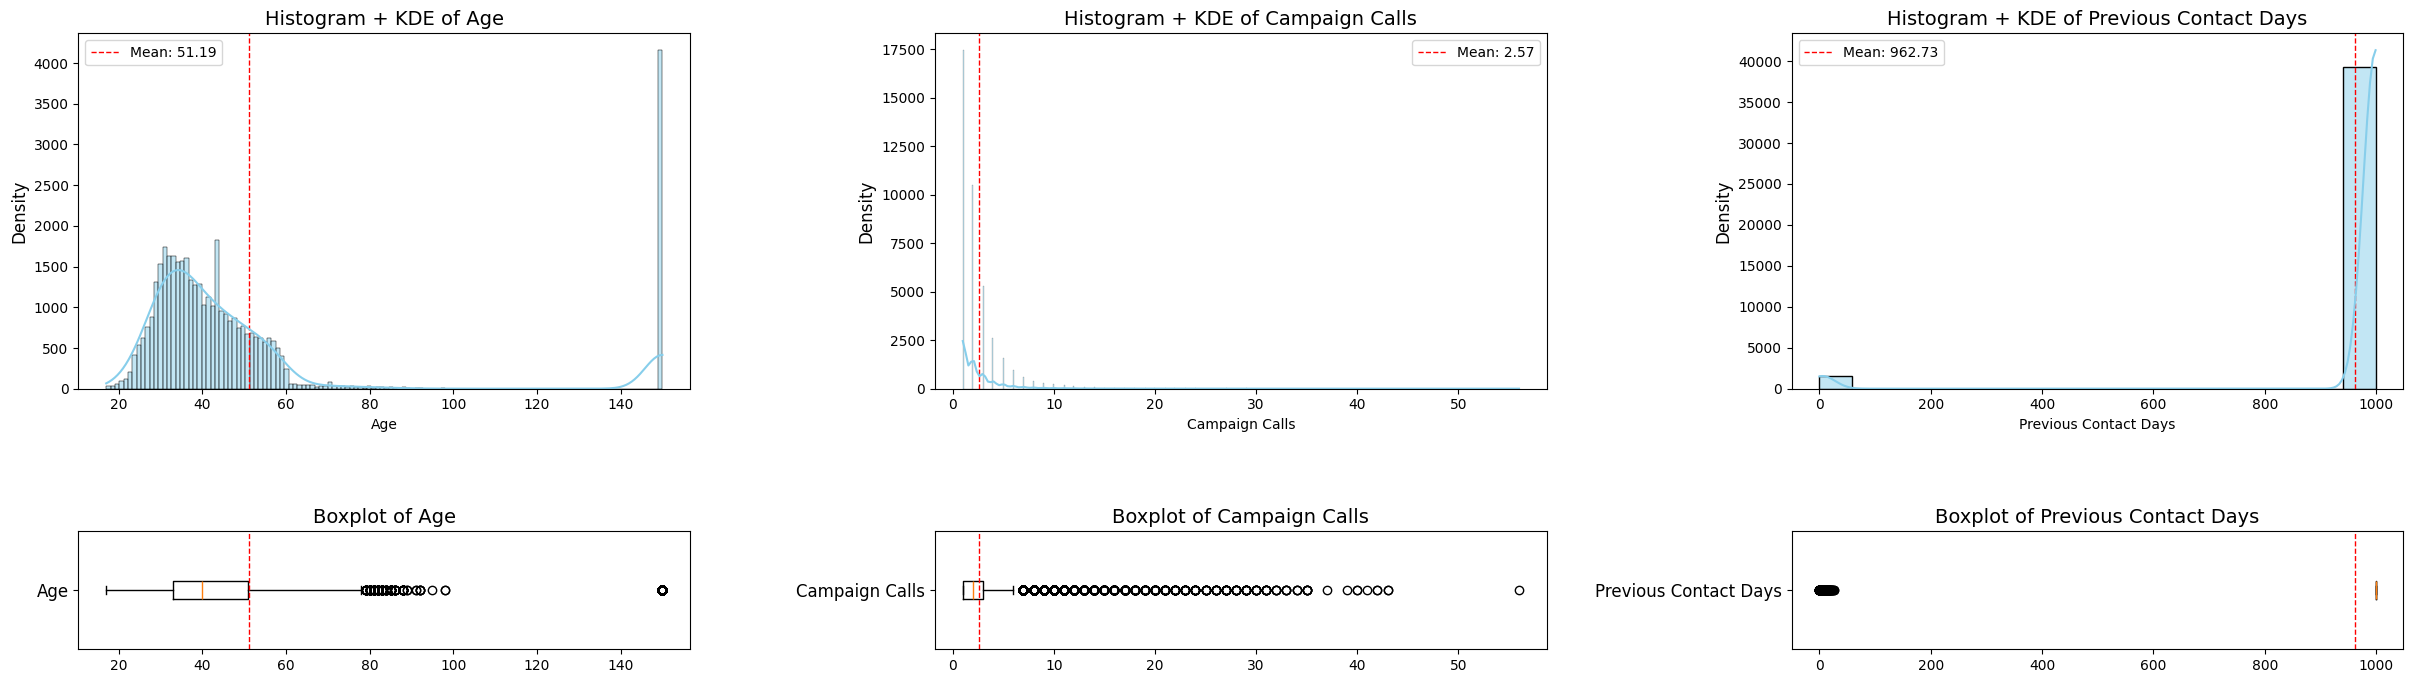

,Age,Campaign Calls,Previous Contact Days
count,40787.000000,40787.000000,40787.000000
mean,51.192145,2.566112,962.725427
std,34.719498,2.768103,186.293432
min,17.000000,1.000000,0.000000
25%,33.000000,1.000000,999.000000
50%,40.000000,2.000000,999.000000
75%,51.000000,3.000000,999.000000
max,150.000000,56.000000,999.000000


In [29]:
# 5. Generate boxplot to visualise our continuous variables
plot_col_header = client_details_cont_df.columns.to_list()
header_count = len(plot_col_header)
plot_histo_and_boxplot(client_details_cont_df, plot_col_header)

display(client_details_df.describe())

### Analysis of Continous Variables:
After the initial cleaning process of categorical variables, lets examine the continuous columns of our dataset.

#### **'Age' Column**:  
---
Our sample's age demographic ranges from 17 years old to 150 years old, with the mean age being 50.35 years old, signifying an older age demographic.  
A long right-tailed distribution is observed. This implies extremely large values with lower count, with the middle 50% of our samples being within their early 30s to early 50s. The outlier value of 150 is also observed, which heavily skewed the mean age (50.35 vs median of 40.0). This mean value projects a false age demographic about our sample.
The outlier value of 150 is likely to be an error, as it is unlikely for somone one to be 150 years old

#### **'Campaign Calls' Column**:  
---
The range of campaign calls is between 1 to 56 calls, with the mean value being approximately 2.6 calls.  
A long tailed distribution is observed which implies the presences of outlying values within our sample. One example of an extreme value observed is 56. Logically speaking, contacting an customer 56 times is not very likely consider the fact that 75% of customer have only been contact 3 times. This implies that the value of 56 is an error. 
The mean and median value is relatively close, implying the majority of data points are tightly clustered around the value of 1 to 3.


#### **'Previous Contact Days' Column**:  
---
The range of previous contact days is between 0 to 999, with the mean value being 956.4 days.
An long tailed distribution is also observed, implying the presences of outlying values. However, this is intentional as the value of `999` is not an error and represents no prior contact. One interesting observation is majority of the data point are `999` as values above the 25th percentile is 999. This implies that the majority of customer in our sample are new leads, having no prior contacts from the bank. Statistically, the outlier skews the mean. This projects an misleading statistic of the average number of days since the last contact. 

#### **Conclusion**:  
---
Outliers have been observed in the three variables which can lead to misleading conclusions about our sample and impact predictive model performance. Subsequent steps will be taken to address these errors. One options is to bin our continous variables into different groups so that we may retain these rows and it's meaning.



### Predictor Variable - 'Age' post removing outlier

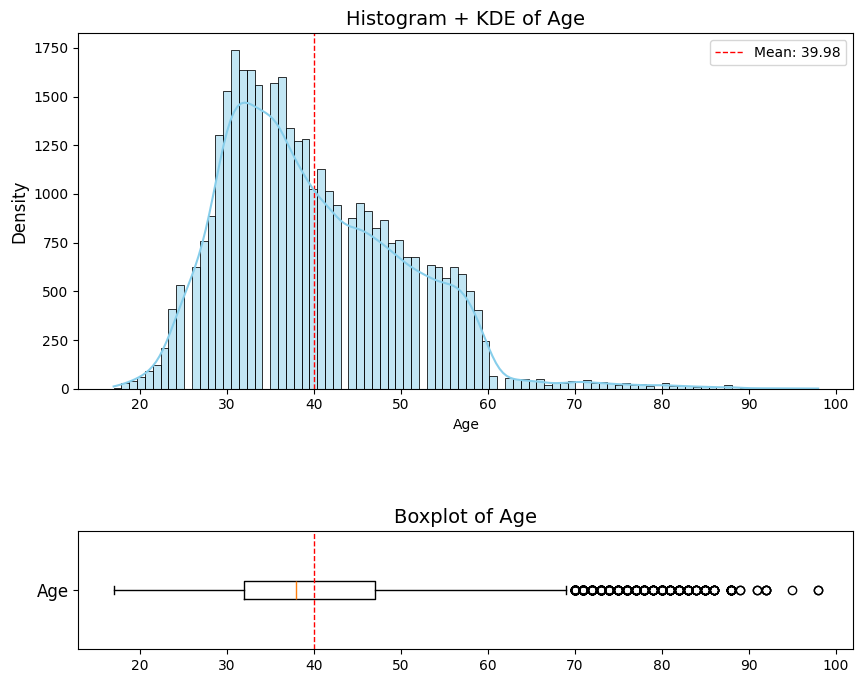

,Stats
count,36630.000000
mean,39.978815
std,10.416864
min,17.000000
25%,32.000000
50%,38.000000
75%,47.000000
max,98.000000


In [30]:
# 5.1 Examining the 'Age' feature and removing the outlier values
extreme_age_mask = client_details_cont_df['Age'] == 150
no_outlier = client_details_cont_df[~extreme_age_mask]
plot_col_header = ['Age']
header_count = len(plot_col_header)
plot_histo_and_boxplot(no_outlier, plot_col_header)
no_outlier_age_df = no_outlier['Age'].to_frame(name = "Stats").reset_index(drop= True) 
display(no_outlier_age_df.describe())

#### 'Age' Variable
---
The mean (40 years) and median (38 years) age are much closer after removing extreme data points, providing us with a much more accurate representation of our sample. Our sample has a much younger age demographic, with the middle 50% ranging from 32 to 38 years old.  

The boxplot diagram displays stastistical outliers. However, these values are likely to not be errors within the data given the longevity of our population. Removing these values would not be appropriate as information is being lost.


### Predictor Variable - 'Previous Contact Days' post removing outlier

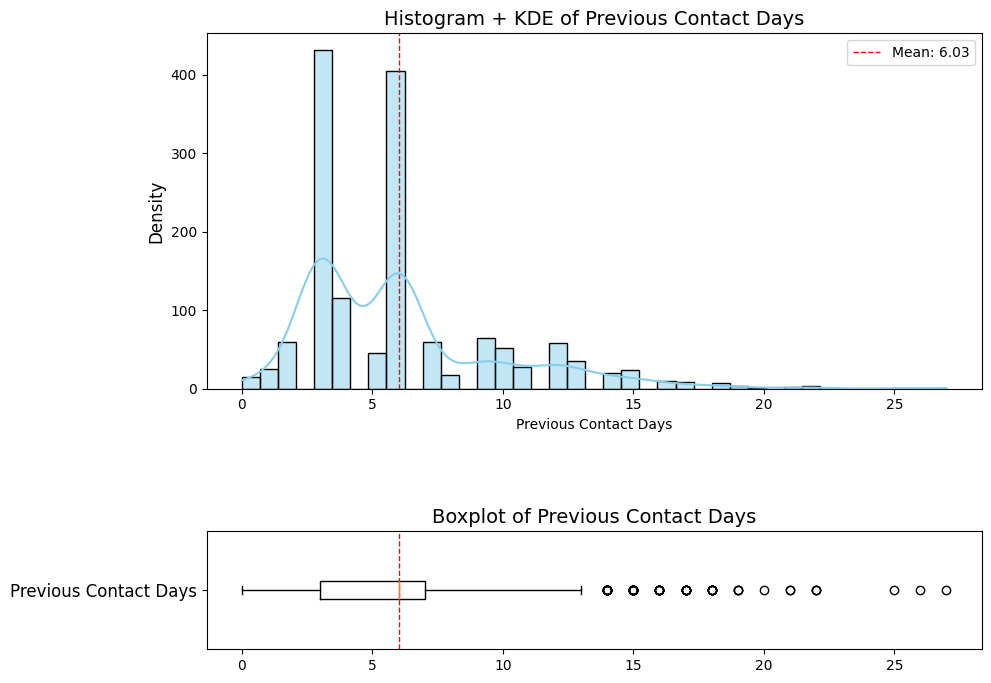

,Stats
count,1490.000000
mean,6.026174
std,3.829297
min,0.000000
25%,3.000000
50%,6.000000
75%,7.000000
max,27.000000


In [31]:
# 5.2 Examining the 'Previous Contact Days' feature
extreme_days_mask = client_details_cont_df['Previous Contact Days'] == 999
no_outlier = client_details_cont_df[~extreme_days_mask]
plot_col_header = ['Previous Contact Days']
header_count = len(plot_col_header)
plot_histo_and_boxplot(no_outlier, plot_col_header)
no_outlier_days_df = no_outlier['Previous Contact Days'].to_frame(name = "Stats").reset_index(drop= True) 
display(no_outlier_days_df.describe())

#### 'Previous Contact Days' Variable
---
Removing outlier gives us a clearer picture of the variable, with the mean value and median value being approximately 6. A bi-model distribution is also observed, implying that the common timeframe between the last contact being 3 days or 6 days. Notably, 75% of customers receives a follow up call within 7 days.
The boxplot diagram display statistical outliers, with the upper bound at around 13 day, which may affect further analysis but this will be corrected.

### Predictor Variable - 'Campaign Calls' post removing outlier

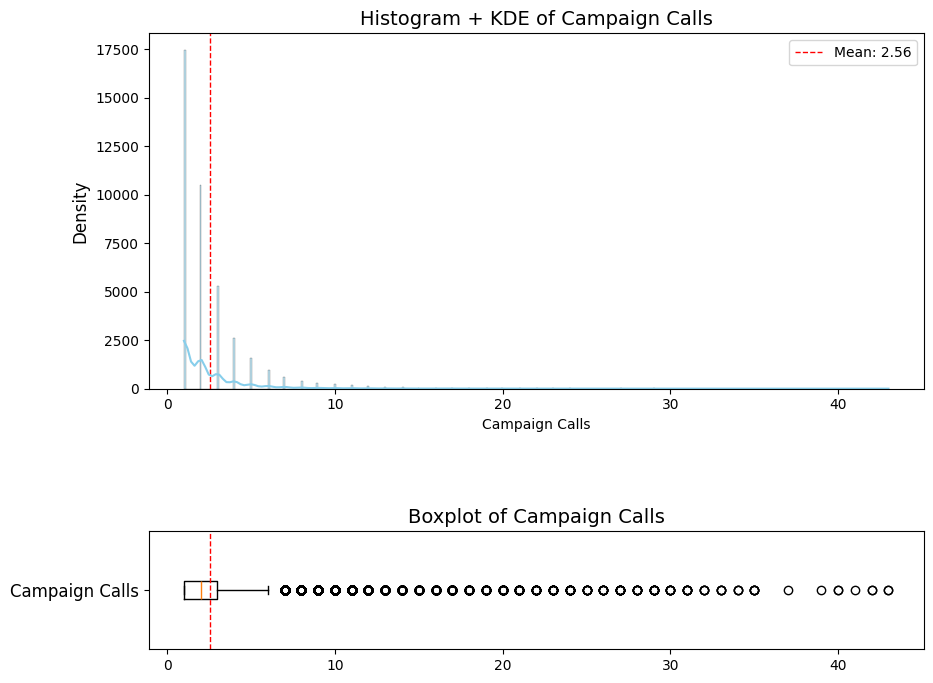

,Stats
count,40786.000000
mean,2.564802
std,2.755463
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,43.000000


In [32]:
# 5.3 Examining 'Campaign Calls'
extreme_calls_mask = client_details_cont_df['Campaign Calls'] == 56
no_outlier = client_details_cont_df[~extreme_calls_mask]
plot_col_header = ['Campaign Calls']
header_count = len(plot_col_header)
plot_histo_and_boxplot(no_outlier, plot_col_header)
no_outlier_calls_df = no_outlier['Campaign Calls'].to_frame(name = "Stats").reset_index(drop= True) 
display(no_outlier_calls_df.describe())

#### 'Campaign Calls' Variable
---
Removing outliers does not change much of the statistic for this variable. the variable ranges from 1 to 43, with the average calls being 2.6.  
75% of the data points is at most 3 calls, implying that 75% of customer is contacted at most 3 times during the campaign.
The boxplot diagram display statistical outliers which may affect further analysis but this will be corrected.

### Scatterplot Analysis for existing leads - Previous Contact Days vs. Campaign Calls by Subscription Status

       Previous Contact Days  Campaign Calls
count           40787.000000    40787.000000
mean              962.725427        2.566112
std               186.293432        2.768103
min                 0.000000        1.000000
25%               999.000000        1.000000
50%               999.000000        2.000000
75%               999.000000        3.000000
max               999.000000       56.000000


(1490, 3)

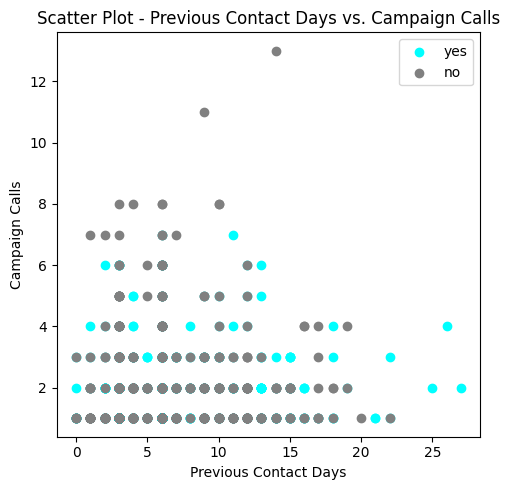

,Previous Contact Days,Campaign Calls
count,1490.000000,1490.000000
mean,6.026174,1.822148
std,3.829297,1.237936
min,0.000000,1.000000
25%,3.000000,1.000000
50%,6.000000,1.000000
75%,7.000000,2.000000
max,27.000000,13.000000


In [33]:
# 5.4 Plot a Scatterplot for existing leads - Previous Contact Days vs. Campaign Class (grouping = target)
scatter_df = client_details_df[['Previous Contact Days','Campaign Calls','Subscription Status']]
print(scatter_df.describe())

extreme_days_mask = scatter_df['Previous Contact Days'] == 999
existing_lead_df = scatter_df[~extreme_days_mask]
existing_lead_df.reset_index(drop = True, inplace = True)
display(existing_lead_df.shape)

plt.figure(figsize=(5, 5))

# Use a dictionary to map groups to colors
color_map = {'yes': 'cyan', 'no':'gray'}

# Create the scatter plot, using the Target variable to determine the color
for group_name, color in color_map.items():
    grouped_data = existing_lead_df[existing_lead_df['Subscription Status'] == group_name]
    plt.scatter(x = grouped_data['Previous Contact Days'], y = grouped_data['Campaign Calls'],
                color = color, label = group_name)

plt.xlabel('Previous Contact Days')
plt.ylabel('Campaign Calls')
plt.title('Scatter Plot - Previous Contact Days vs. Campaign Calls')
plt.legend()
# plt.grid(True)
plt.tight_layout()
# Display the plot
plt.show()
display(existing_lead_df.describe())



#### Scatterplot - Previous Contact Days vs. Campaign Calls by Subscription Status
---

Examining the scatterplot above, there are three clusters being formed. Two of three clusters are mostly consist of customer who responsed positively to the campaign.

Cluster 01: Mostly did not subscribe  
The boundary of this cluster
* 0 - 12 days  
* 1 - 3 calls  

These customers are characterised as recently contacted and lightly followed up. This cluster of customers are likely to have little or no interest

Cluster 02: Mostly subscribe
The boundary of this cluster
* 13 - 25 days  
* 1 - 4 calls  

These customers are characterised as having a sizeable gap (about 2 weeks) since the last campaign and moderately followed up. This cluster of customers are respond positively after a period of time with mild follow up.

Cluster 03: Mostly subscribe
The boundary of this cluster
* 0 - 12 days  
* 4 - 7 calls  

These customers can be characterised as responding positively to aggressive and quick follow ups. This cluster of customer are likely to have developed an interest from the previous campaign.

This insight allows for strategic folloup with exisiting leads. Cluster 2 requires patience (by giving customers some thinking time) and mild follow-up to maintain customer interest and buy in while Cluster 3 requires quick and aggressive follow-up for customer buy in.  

### Boxplot for New leads - Campaign Calls by Subscription Status

(39297, 3)

C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\376271851.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Campaign Calls',


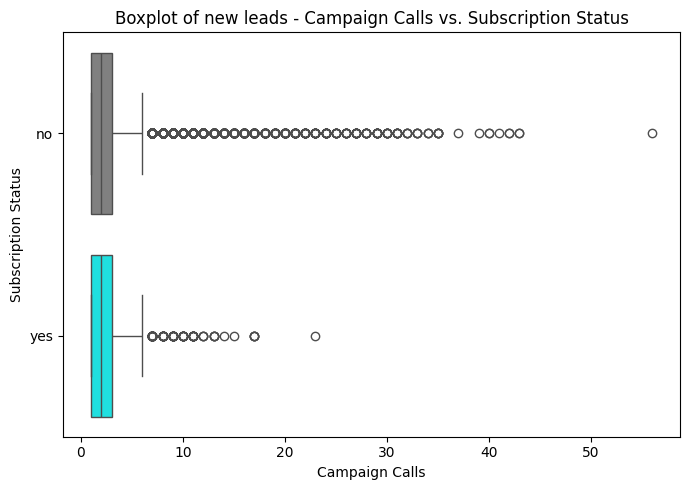

,count,mean,std,min,25%,50%,75%,max
Subscription Status,,,,,,,,
no,35660.0,2.640578,2.886576,1.0,1.0,2.0,3.0,56.0
yes,3637.0,2.140775,1.773314,1.0,1.0,2.0,3.0,23.0


In [34]:
# 5.5 Plot a graph for new leads
new_lead_df = scatter_df[extreme_days_mask]
new_lead_df.reset_index(drop = True, inplace = True)
display(new_lead_df.shape)

plt.figure(figsize=(7, 5))

# Create the scatter plot, using the target variable to determine the color
sns.boxplot(x = 'Campaign Calls',
            y = 'Subscription Status',
            data = new_lead_df,
            palette={'yes': 'cyan', 'no': 'gray'})

plt.xlabel('Campaign Calls')
plt.title('Boxplot of new leads - Campaign Calls vs. Subscription Status')
plt.tight_layout()
# Display the plot
plt.show()

quart_vals = new_lead_df.groupby('Subscription Status')['Campaign Calls'].describe()
display(quart_vals)

#### Boxplot - Campaign Calls by Subscription Status
---
The above boxplot is based off new leads (where `Previous Contact Days` = 999). Using the quartile values, we do not observe a difference between the subscription status. However, customers that did not subscribe had an average of 2.6 calls (vs. 2.1 calls) when we examine the outliers. This implies that campaign calls may not be important factor in getting customer buy in, but customer do not buy in when calls pass a threshold.

## 6. Feature Engineering
* Binning of 'Previous Contact Day' -> 'Previous Contact Period'
* Binning of 'Age' -> 'Age_Group'
* Binning of 'Campaign Calls'

In [35]:
# 4.0 Binning 'Previous Contact Days' into different time span
no_contact_mask = client_details_df['Previous Contact Days'] == 999
no_contact_df = client_details_df[no_contact_mask]
contact_df = client_details_df[~no_contact_mask].sort_values(by = ['Previous Contact Days'], ascending = True)

no_contact_df['Previous_Contact_Days_Passed'] = "No Prior Contact"

bins = [0,7,14,21,28,float(np.inf)]
labels = ['Within One Week ', 'One Week Passed', 'Two Weeks Passed','Three Weeks Passed', 'One Month Passed']
contact_df['Previous_Contact_Days_Passed'] = pd.cut(contact_df['Previous Contact Days'], bins = bins, labels = labels, right = True, include_lowest = True)

client_details_df = pd.concat([no_contact_df, contact_df], axis = 0)
client_details_df.reset_index(drop = True, inplace = True)
display(client_details_df.head(5))

C:\Users\Tan Chong Zheng\AppData\Local\Temp\ipykernel_11692\633236716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_contact_df['Previous_Contact_Days_Passed'] = "No Prior Contact"


,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Previous_Contact_Days_Passed
0,56,housemaid,married,basic_4y,no,no,no,telephone,1,999,no,No Prior Contact
1,150,services,married,high_school,no,no,no,telephone,1,999,no,No Prior Contact
2,37,services,married,high_school,no,yes,no,telephone,1,999,no,No Prior Contact
3,150,admin,married,basic_6y,no,no,no,telephone,1,999,no,No Prior Contact
4,56,services,married,high_school,no,yes,yes,telephone,1,999,no,No Prior Contact


In [36]:
# 4.1 Binning 'Age'
extreme_age_mask = client_details_df['Age'] == 150
no_extreme_age_df = client_details_df[~extreme_age_mask]
no_extreme_age_df.reset_index(drop = True, inplace = True)

In [37]:
# 4.1.1 Setup the KBinDiscretizer object
kBinner_age = KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='quantile', random_state = 42).set_output(transform="pandas")
bins_age = kBinner_age.fit_transform(no_extreme_age_df[['Age']])
bins_age.columns = ['Age_group']
bins_age = bins_age.astype('str')
bins_age.reset_index(drop = True, inplace = True)
print(kBinner_age.bin_edges_)
print(bins_age.shape)

[array([17., 32., 38., 47., 98.])]
(36630, 1)


In [38]:
# 4.1.2 Merge the binning results
no_extreme_age_df = pd.concat([no_extreme_age_df, bins_age], axis = 1)
client_details_df = no_extreme_age_df
client_details_df.reset_index(drop = True, inplace = True)
client_details_df['Age_group'] = "age_grp_" + client_details_df['Age_group']
display(client_details_df.shape)
display(client_details_df.tail(5))

(36630, 13)

,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Previous_Contact_Days_Passed,Age_group
36625,28,management,single,university_degree,no,yes,no,cell,1,22,yes,Three Weeks Passed,age_grp_0.0
36626,38,technician,single,professional_course,no,yes,no,cell,3,22,yes,Three Weeks Passed,age_grp_2.0
36627,60,admin,married,basic_9y,no,no,no,cell,2,25,yes,Three Weeks Passed,age_grp_3.0
36628,24,technician,married,professional_course,no,no,no,cell,4,26,yes,Three Weeks Passed,age_grp_0.0
36629,41,technician,married,professional_course,no,yes,no,cell,2,27,yes,Three Weeks Passed,age_grp_2.0


In [39]:
# Binning 'Campaign Calls'
bins = [0, 3, 7, 10,float(np.inf)]
labels = ['call_grp_0-3', 'call_grp_4-7', 'call_grp_8-10','call_grp_10+']
client_details_df['Call_Groups'] = pd.cut(client_details_df['Campaign Calls'], bins = bins, labels = labels, right = True, include_lowest = True)
client_details_df['Call_Groups'] = client_details_df['Call_Groups'].astype('str')
display(client_details_df)
print(f'The final Dataset has {client_details_df.shape[0]} rows, {client_details_df.shape[1]} columns')

,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Previous_Contact_Days_Passed,Age_group,Call_Groups
0,56,housemaid,married,basic_4y,no,no,no,telephone,1,999,no,No Prior Contact,age_grp_3.0,call_grp_0-3
1,37,services,married,high_school,no,yes,no,telephone,1,999,no,No Prior Contact,age_grp_1.0,call_grp_0-3
2,56,services,married,high_school,no,yes,yes,telephone,1,999,no,No Prior Contact,age_grp_3.0,call_grp_0-3
3,45,services,married,basic_9y,no,no,no,telephone,1,999,no,No Prior Contact,age_grp_2.0,call_grp_0-3
4,59,admin,married,professional_course,no,yes,no,telephone,1,999,no,No Prior Contact,age_grp_3.0,call_grp_0-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36625,28,management,single,university_degree,no,yes,no,cell,1,22,yes,Three Weeks Passed,age_grp_0.0,call_grp_0-3
36626,38,technician,single,professional_course,no,yes,no,cell,3,22,yes,Three Weeks Passed,age_grp_2.0,call_grp_0-3
36627,60,admin,married,basic_9y,no,no,no,cell,2,25,yes,Three Weeks Passed,age_grp_3.0,call_grp_0-3
36628,24,technician,married,professional_course,no,no,no,cell,4,26,yes,Three Weeks Passed,age_grp_0.0,call_grp_4-7


The final Dataset has 36630 rows, 14 columns


## 7. Cleaning up the Dataset
* Removing unnessary columns
* Resetting the index (for good measure)

In [40]:
cols_to_drop = ["Age","Previous Contact Days","Campaign Calls"]
client_details_df.drop(columns = cols_to_drop, inplace = True)
client_details_df.reset_index(drop = True, inplace = True)
display(client_details_df.describe())
print(f'The final Dataset has {client_details_df.shape[0]} rows, {client_details_df.shape[1]} columns')

,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Subscription Status,Previous_Contact_Days_Passed,Age_group,Call_Groups
count,36630,36630,36630,36630,36630,36630,36630,36630,36630,36630,36630
unique,11,3,7,2,2,2,2,2,5,4,4
top,admin,married,university_degree,no,yes,no,cell,no,No Prior Contact,age_grp_3.0,call_grp_0-3
freq,9343,22140,10858,36627,30058,31641,23301,32482,35279,9558,29827


The final Dataset has 36630 rows, 11 columns


In [41]:
display(client_details_df.head(5))

,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Subscription Status,Previous_Contact_Days_Passed,Age_group,Call_Groups
0,housemaid,married,basic_4y,no,no,no,telephone,no,No Prior Contact,age_grp_3.0,call_grp_0-3
1,services,married,high_school,no,yes,no,telephone,no,No Prior Contact,age_grp_1.0,call_grp_0-3
2,services,married,high_school,no,yes,yes,telephone,no,No Prior Contact,age_grp_3.0,call_grp_0-3
3,services,married,basic_9y,no,no,no,telephone,no,No Prior Contact,age_grp_2.0,call_grp_0-3
4,admin,married,professional_course,no,yes,no,telephone,no,No Prior Contact,age_grp_3.0,call_grp_0-3


### 8. Exploratory Data Analysis (EDA)
* https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/


In [42]:
# Prepare our Dataset for Association Rule Mining (ARM) and better clarity
arm_df = client_details_df
arm_df['Housing Loan'] = arm_df['Housing Loan'] + '_hl'
arm_df['Personal Loan'] = arm_df['Personal Loan'] + '_pl'
arm_df['Credit Default'] = arm_df['Credit Default'] + '_cd'
arm_df['Subscription Status'] = 'target_' + arm_df['Subscription Status']
arm_df.reset_index(drop = True, inplace = True)
display(arm_df.head(5))


,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Subscription Status,Previous_Contact_Days_Passed,Age_group,Call_Groups
0,housemaid,married,basic_4y,no_cd,no_hl,no_pl,telephone,target_no,No Prior Contact,age_grp_3.0,call_grp_0-3
1,services,married,high_school,no_cd,yes_hl,no_pl,telephone,target_no,No Prior Contact,age_grp_1.0,call_grp_0-3
2,services,married,high_school,no_cd,yes_hl,yes_pl,telephone,target_no,No Prior Contact,age_grp_3.0,call_grp_0-3
3,services,married,basic_9y,no_cd,no_hl,no_pl,telephone,target_no,No Prior Contact,age_grp_2.0,call_grp_0-3
4,admin,married,professional_course,no_cd,yes_hl,no_pl,telephone,target_no,No Prior Contact,age_grp_3.0,call_grp_0-3


In [43]:
arm_df = arm_df[arm_df['Subscription Status'] == 'target_yes']
data_ary = arm_df.values.tolist()
print(data_ary[0])

['blue-collar', 'divorced', 'basic_4y', 'no_cd', 'yes_hl', 'no_pl', 'telephone', 'target_yes', 'No Prior Contact', 'age_grp_2.0', 'call_grp_0-3']


In [44]:
# Transform our DataFrame into a suitable data struture for ARM
te = TransactionEncoder()
encoded_array = te.fit(data_ary).transform(data_ary)
df = pd.DataFrame(encoded_array, columns= te.columns_)
display(df.head(3))

,No Prior Contact,One Week Passed,Three Weeks Passed,Two Weeks Passed,Within One Week,admin,age_grp_0.0,age_grp_1.0,age_grp_2.0,age_grp_3.0,...,services,single,student,target_yes,technician,telephone,unemployed,university_degree,yes_hl,yes_pl
0,True,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,True,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,True,False,True,True,False
2,True,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,True,False,False,False,False


In [45]:
# Generate Frequent itemsets with the FP-Max algo
freq_itemsets_max = fpmax(df, min_support=0.7, use_colnames=True)

# Check the item set
print(freq_itemsets_max.shape)
display(freq_itemsets_max)

(6, 2)


,support,itemsets
0,0.791948,"(target_yes, No Prior Contact, no_cd)"
1,0.706365,"(target_yes, no_pl, yes_hl, no_cd)"
2,0.724446,"(target_yes, yes_hl, call_grp_0-3, no_cd)"
3,0.718901,"(target_yes, cell, no_pl, no_cd)"
4,0.739875,"(target_yes, cell, call_grp_0-3, no_cd)"
5,0.763983,"(target_yes, no_pl, call_grp_0-3, no_cd)"


In [ ]:
# Generate Rulesets based on the frequently occuring itemsets; rules are selected based on their confidence level
# rulesets = association_rules(freq_itemsets_max, metric="confidence", min_threshold=0.2)
rulesets = association_rules(freq_itemsets_max, support_only = True, min_threshold=0.01)
rulesets["antecedent_length"] = rulesets["antecedents"].apply(lambda x: len(x))
rulesets = rulesets[rulesets["consequents"] == frozenset({'target_yes'})]
rulesets = rulesets[["antecedents","consequents","support"]]
# rulesets = rulesets[rulesets["antecedent_length"] >= 4]
rulesets.reset_index(inplace = True, drop = True)
# print(rulesets.shape)
display(rulesets)

,antecedents,consequents,support
0,"(No Prior Contact, no_cd)",(target_yes),0.791948
1,"(no_pl, yes_hl, no_cd)",(target_yes),0.706365
2,"(call_grp_0-3, yes_hl, no_cd)",(target_yes),0.724446
3,"(cell, no_pl, no_cd)",(target_yes),0.718901
4,"(no_cd, cell, call_grp_0-3)",(target_yes),0.739875
5,"(no_cd, no_pl, call_grp_0-3)",(target_yes),0.763983



#### Ruleset interpretation

> Assumptions:  
> 1. we are only interested in ruleset that co-occur with a successful subscription 
> 2. There is an meaningful divide between cellphone and telephone - e.g. cellphone owners may have a higher socio-economic background compared to telephone owners
> 3. levels of marketing refer to amount of calls during the campaign. e.g. light marketing refer to 0 - 3 follow-up calls to the customer.

* Ruleset 1 - New leads with no credit default 
* Ruleset 2 - Customer serving a Housing loan, without personal loan and no credit default
* Ruleset 3 - Customers who received light amount of calls (0 to 3) throughout the campaign, serving a Housing loan with no credit default
* Ruleset 4 - Customer contacted through cellphone with no personal loan and no credit default
* Ruleset 5 - Customers who received light amount of calls (0 to 3) throughout the campaign, no credit default and contacted through cellphone
* Ruleset 6 - Customers who received light amount of calls (0 to 3) throughout the campaign, no credit default and no personal loan

#### Insights
---
Ruleset 1 identifies subscribers to be new leads (Previous Contact Days = 999) with great level of financial stability. The understanding is that someone with a credit default would focus their available money to pay off their financial obligations. Therefore, they would not have the resources to subscribe to a term deposit.

Ruleset 2 identifies subscribers as home-owners with healthy levels of financial stability and capability. The understanding is that home-owners may have some available resources for short-term investment but possess a lower risk appetite due to the outstanding housing loan.

Ruleset 3 idenitifies subscribers as home-owners with healthy levels of financial stability. These subscriber is likely to response better to lighter levels of marketing. With references to the scatterplot, this group of subscribers is likely to belong to Cluster 02. The understanding is that this group of subscribers are home-owners who developed interest in the term deposit from prior contact. 

Ruleset 4  identifies subscribers as customers with healthy levels of financial capability and stability, contactable via cellphone. Considering the assumption of an meaningful divide between cellphone and telephone, the understanding is that this group of subscribers are cellphone owners with higher socioeconomic status and healthy financial capability and stablility with lower risk appetite.

Ruleset 5 identifies subscribers as customers with healthy levels of financial stability, who are contactable via cellphone and response better to lighter levels of marketing. Considering the assumption of an meaningful divide between cellphone and telephone, the understanding is that this group of subscribers are cellphone owners with higher socioeconomic status and healthy financial capabilities and stablilities with lower risk appetite.

Ruleset 6 identifies identifies subscribers as customers with healthy levels of financial capability and stability, responding better to lighter levels of marketing.

#### Suggestion
---
Based on the Interpretation of the ruleset, suggestion are as follows:

* Focus on home-owners with healthy financial status   
* Focus on Customer with higher socio-economic status (as denoted by cellphone ownership) and healthy financial status
* Avoid aggressive levels of marketing (high amount of follow-up calls)
